# Laboratorio 4: Clasificación de Imágenes con CNN (CIFAR-10)

**Integrantes**
- José Rodrigo Marchena, 22398  
- Sofía Velasquez, 22049  

**Objetivo general**  
Implementar y comparar un modelo base ANN y una CNN para clasificar el dataset CIFAR-10,evaluando desempeño, curvas de aprendizaje y errores comunes. También se incluye un ejercicio opcional de Data Augmentation.

---

## Parte 1: Preparación del Conjunto de Datos

1. Cargamos el dataset CIFAR-10 directamente desde `keras.datasets`.  
   - Son 60,000 imágenes de tamaño 32x32x3 (RGB).  
   - Se dividen en 50,000 de entrenamiento y 10,000 de prueba.  
2. Normalizamos los valores de píxeles, dividiéndolos entre 255, de modo que los valores queden en el rango [0,1]
3. Definimos los nombres de las clases (avión, coche, perro, etc.).  
4. Mostramos 10 imágenes de entrenamiento con sus etiquetas para confirmar que los datos están bien cargados.

Shapes -> x_train: (50000, 32, 32, 3) y_train: (50000, 1)
Shapes -> x_test: (10000, 32, 32, 3) y_test: (10000, 1)


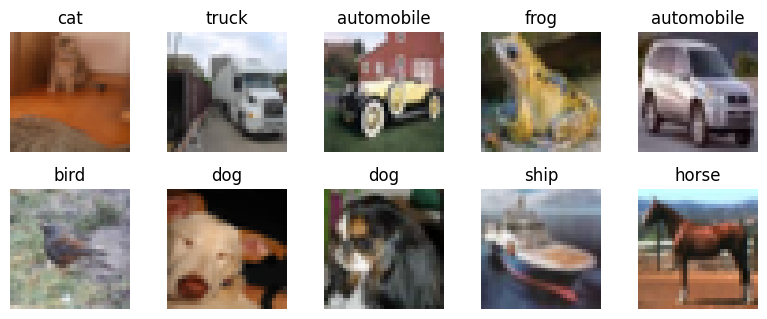

In [1]:
# Carga de CIFAR-10
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

print("Shapes -> x_train:", x_train.shape, "y_train:", y_train.shape)
print("Shapes -> x_test:", x_test.shape, "y_test:", y_test.shape)

# Normalización [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Visualización de 10 ejemplos
def show_grid(images, labels, n=10):
    plt.figure(figsize=(8,8))
    idx = np.random.choice(len(images), n, replace=False)
    for i, j in enumerate(idx):
        plt.subplot(5,5,i+1)
        plt.imshow(images[j])
        plt.title(class_names[labels[j][0]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_grid(x_train, y_train)

### Parte 2: Modelo Base ANN

Aquí implementamos una red neuronal artificial densa (ANN):

- Se aplana la imagen (32×32×3 → 3072 neuronas).  
- Dos capas densas ocultas con activación ReLU.  
- Capa final Dense(10) con activación Softmax para clasificar las 10 clases.  

Se compila el modelo con:
- **Optimizer:** Adam.  
- **Loss:** categorical_crossentropy.  
- **Métrica:** Accuracy.  

Luego lo entrenamos, medimos tiempo de entrenamiento y evaluamos el rendimiento en el set de prueba.

In [2]:
import time
from tensorflow.keras.utils import to_categorical

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

def build_ann(input_shape=(32,32,3), num_classes=10):
    model = keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

ann = build_ann()
ann.summary()

c:\Users\50250\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Entrenamiento ANN (midiendole el tiempo)
batch_size = 64
epochs = 10

start = time.time()
hist_ann = ann.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2
)
t_train_ann = time.time() - start
print(f"Tiempo de entrenamiento ANN: {t_train_ann:.2f} s")

# Evaluación del modelo en test
test_loss_ann, test_acc_ann = ann.evaluate(x_test, y_test, verbose=0)
print(f"[ANN] Test Acc: {test_acc_ann:.4f} | Test Loss: {test_loss_ann:.4f}")


Epoch 1/10
625/625 - 8s - 12ms/step - accuracy: 0.3249 - loss: 1.8903 - val_accuracy: 0.3521 - val_loss: 1.7888
Epoch 2/10
625/625 - 6s - 10ms/step - accuracy: 0.3919 - loss: 1.7006 - val_accuracy: 0.3943 - val_loss: 1.6951
Epoch 3/10
625/625 - 7s - 11ms/step - accuracy: 0.4286 - loss: 1.6117 - val_accuracy: 0.4319 - val_loss: 1.6089
Epoch 4/10
625/625 - 7s - 11ms/step - accuracy: 0.4448 - loss: 1.5512 - val_accuracy: 0.4242 - val_loss: 1.5949
Epoch 5/10
625/625 - 7s - 11ms/step - accuracy: 0.4558 - loss: 1.5186 - val_accuracy: 0.4441 - val_loss: 1.5554
Epoch 6/10
625/625 - 6s - 10ms/step - accuracy: 0.4719 - loss: 1.4786 - val_accuracy: 0.4489 - val_loss: 1.5499
Epoch 7/10
625/625 - 6s - 10ms/step - accuracy: 0.4827 - loss: 1.4489 - val_accuracy: 0.4703 - val_loss: 1.5087
Epoch 8/10
625/625 - 7s - 11ms/step - accuracy: 0.4930 - loss: 1.4179 - val_accuracy: 0.4712 - val_loss: 1.4890
Epoch 9/10
625/625 - 7s - 12ms/step - accuracy: 0.5021 - loss: 1.3966 - val_accuracy: 0.4851 - val_loss:

## Parte 3: Implementación de CNN

Diseñamos una red neuronal convolucional (CNN) para mejorar el desempeño:

- Varias capas Conv2D con filtros (32, 64, 128).  
- Capas de MaxPooling2D para reducir la dimensión espacial.  
- Dropout en puntos estratégicos para reducir sobreajuste.  
- Al final, una capa densa y salida Softmax de 10 clases.  

Entrenamos el modelo usando validación y `EarlyStopping` para detener si no mejora la accuracy en validación.  
Se registra el tiempo de entrenamiento y se evalúa con los datos de prueba.

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def build_cnn(input_shape=(32,32,3), num_classes=10, dropout_rate=0.3):
    model = keras.Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Dropout(dropout_rate),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Dropout(dropout_rate),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')  
    ])
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

cnn = build_cnn()
cnn.summary()


c:\Users\50250\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,362 (2.37 MB)

 Trainable params: 620,362 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
early = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

start = time.time()
hist_cnn = cnn.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[early],
    verbose=2
)
t_train_cnn = time.time() - start
print(f"Tiempo de entrenamiento CNN: {t_train_cnn:.2f} s")

test_loss_cnn, test_acc_cnn = cnn.evaluate(x_test, y_test, verbose=0)
print(f"[CNN] Test Acc: {test_acc_cnn:.4f} | Test Loss: {test_loss_cnn:.4f}")

Epoch 1/10
625/625 - 19s - 31ms/step - accuracy: 0.3832 - loss: 1.6835 - val_accuracy: 0.5072 - val_loss: 1.3780
Epoch 2/10
625/625 - 18s - 28ms/step - accuracy: 0.5199 - loss: 1.3238 - val_accuracy: 0.5902 - val_loss: 1.1483
Epoch 3/10
625/625 - 18s - 29ms/step - accuracy: 0.5820 - loss: 1.1712 - val_accuracy: 0.6357 - val_loss: 1.0516
Epoch 4/10
625/625 - 17s - 28ms/step - accuracy: 0.6187 - loss: 1.0711 - val_accuracy: 0.6715 - val_loss: 0.9446
Epoch 5/10
625/625 - 17s - 27ms/step - accuracy: 0.6446 - loss: 1.0041 - val_accuracy: 0.6988 - val_loss: 0.8812
Epoch 6/10
625/625 - 16s - 26ms/step - accuracy: 0.6654 - loss: 0.9497 - val_accuracy: 0.7177 - val_loss: 0.8277
Epoch 7/10
625/625 - 17s - 28ms/step - accuracy: 0.6823 - loss: 0.8989 - val_accuracy: 0.7179 - val_loss: 0.8121
Epoch 8/10
625/625 - 18s - 29ms/step - accuracy: 0.6976 - loss: 0.8624 - val_accuracy: 0.7148 - val_loss: 0.8206
Epoch 9/10
625/625 - 17s - 27ms/step - accuracy: 0.7044 - loss: 0.8326 - val_accuracy: 0.7287 - 